# STEP 1: Import Libraries

In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind


# STEP 2: Load Datasets

In [17]:
# Load Hyperliquid trader data
trades_df = pd.read_csv("//content/historical_data.csv")

# Load Fear & Greed Index
sentiment_df = pd.read_csv("/content/fear_greed_index.csv")


# 3: Initial Data Inspection

In [18]:
trades_df.head()
sentiment_df.head()

trades_df.info()
sentiment_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 non-null  float64
 8   Direction         211224 non-null  object 
 9   Closed PnL        211224 non-null  float64
 10  Transaction Hash  211224 non-null  object 
 11  Order ID          211224 non-null  int64  
 12  Crossed           211224 non-null  bool   
 13  Fee               211224 non-null  float64
 14  Trade ID          211224 non-null  float64
 15  Timestamp         211224 non-null  float64
dtypes: bool(1), float64(

# STEP 4: Data Cleaning

## 4.1 Convert timestamps to Date

In [19]:
# Convert trade timestamp
trades_df['Timestamp IST'] = pd.to_datetime(
    trades_df['Timestamp IST'],
    format="%d-%m-%Y %H:%M"
)

trades_df['date'] = trades_df['Timestamp IST'].dt.date

# Convert sentiment date
sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date


## 4.2 Normalize sentiment labels

In [20]:
sentiment_df['classification'] = sentiment_df['classification'].replace({
    'Extreme Fear': 'Fear',
    'Extreme Greed': 'Greed'
})


##4.3 Select required columns

In [21]:
trades_df = trades_df[
    ['Account', 'Coin', 'Execution Price', 'Size USD',
     'Side', 'Closed PnL', 'Fee', 'date']
]

sentiment_df = sentiment_df[['date', 'classification']]


##4.4 Remove missing values

In [22]:
trades_df.dropna(subset=['Closed PnL'], inplace=True)


# STEP 5: Merge Trader Data with Market Sentiment

In [23]:
merged_df = trades_df.merge(
    sentiment_df,
    on='date',
    how='inner'
)

merged_df.head()


,Account,Coin,Execution Price,Size USD,Side,Closed PnL,Fee,date,classification
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,7872.16,BUY,0.0,0.345404,2024-12-02,Greed
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,127.68,BUY,0.0,0.005600,2024-12-02,Greed
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,1150.63,BUY,0.0,0.050431,2024-12-02,Greed
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,1142.04,BUY,0.0,0.050043,2024-12-02,Greed
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,69.75,BUY,0.0,0.003055,2024-12-02,Greed


# STEP 6: Exploratory Data Analysis (EDA)

## 6.1 Sentiment Distribution

In [24]:
merged_df['classification'].value_counts()


,count
classification,
Greed,90295
Fear,83237
Neutral,37686


##6.2 PnL Distribution by Sentiment

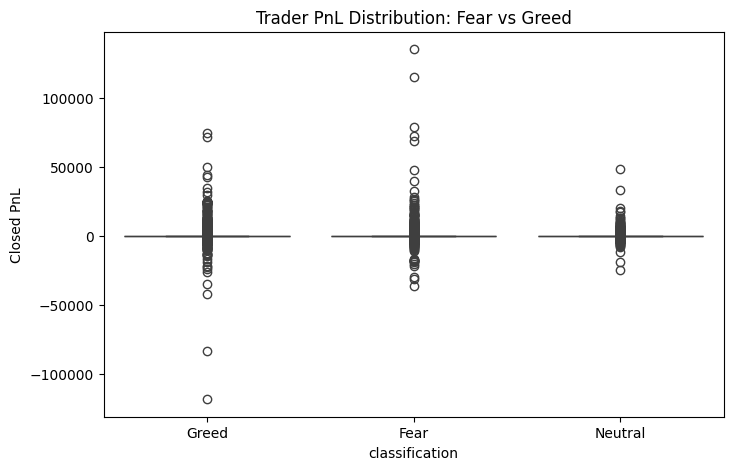

In [25]:
plt.figure(figsize=(8,5))
sns.boxplot(
    data=merged_df,
    x='classification',
    y='Closed PnL'
)
plt.title("Trader PnL Distribution: Fear vs Greed")
plt.show()


##6.3 Average PnL by Sentiment

In [26]:
merged_df.groupby('classification')['Closed PnL'].mean()


,Closed PnL
classification,
Fear,49.212077
Greed,53.882281
Neutral,34.307718


##6.4 Trade Size Behavior

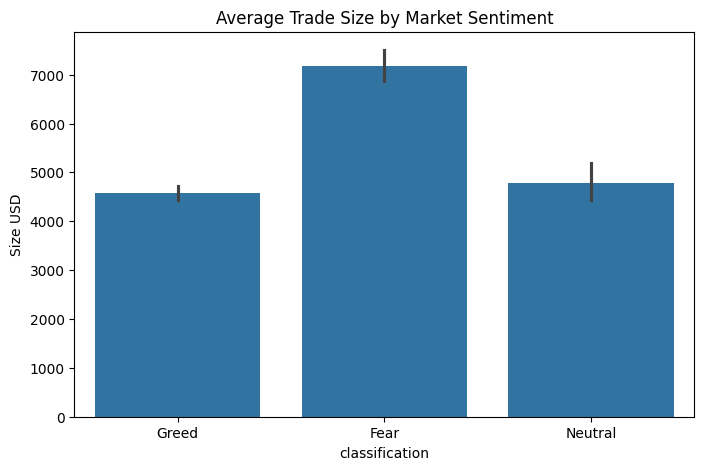

In [27]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=merged_df,
    x='classification',
    y='Size USD'
)
plt.title("Average Trade Size by Market Sentiment")
plt.show()


# STEP 7: Statistical Significance Test
Hypothesis:

Trader PnL differs significantly between Fear and Greed

In [28]:
fear_pnl = merged_df[
    merged_df['classification'] == 'Fear'
]['Closed PnL']

greed_pnl = merged_df[
    merged_df['classification'] == 'Greed'
]['Closed PnL']

t_stat, p_value = ttest_ind(
    fear_pnl,
    greed_pnl,
    equal_var=False
)

t_stat, p_value


(np.float64(-0.9875081966653334), np.float64(0.32339495608436075))

# STEP 8: Trader Performance Segmentation

## 8.1 Aggregate per trader

In [29]:
trader_summary = merged_df.groupby('Account').agg({
    'Closed PnL': ['mean', 'sum'],
    'Size USD': 'mean',
    'Fee': 'sum'
}).reset_index()

trader_summary.columns = [
    'Account', 'Avg_PnL', 'Total_PnL',
    'Avg_Trade_Size', 'Total_Fees'
]


## 8.2 Categorize traders

In [30]:
def trader_label(pnl):
    if pnl > 0:
        return "Consistent Winner"
    elif pnl < 0:
        return "Consistent Loser"
    else:
        return "Neutral"

trader_summary['Category'] = trader_summary['Total_PnL'].apply(trader_label)


## 8.3 Distribution

In [31]:
trader_summary['Category'].value_counts()


,count
Category,
Consistent Winner,29
Consistent Loser,3


# STEP 9: Buy vs Sell Behavior

In [32]:
direction_pnl = merged_df.groupby(
    ['classification', 'Side']
)['Closed PnL'].mean().reset_index()


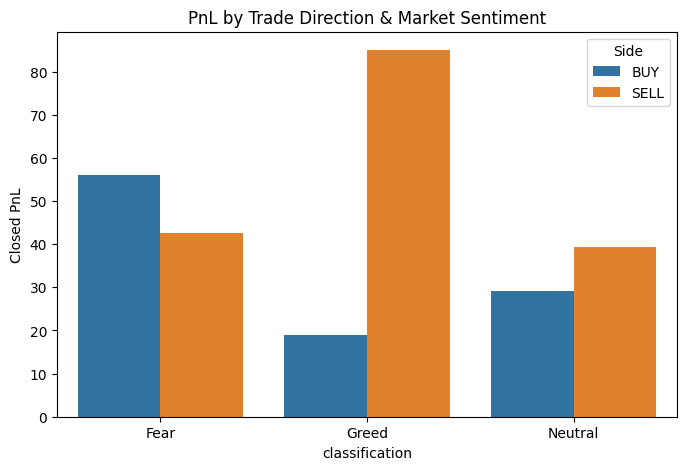

In [33]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=direction_pnl,
    x='classification',
    y='Closed PnL',
    hue='Side'
)
plt.title("PnL by Trade Direction & Market Sentiment")
plt.show()


# STEP 10: Daily PnL Trend

In [34]:
daily_pnl = merged_df.groupby(
    ['date', 'classification']
)['Closed PnL'].sum().reset_index()


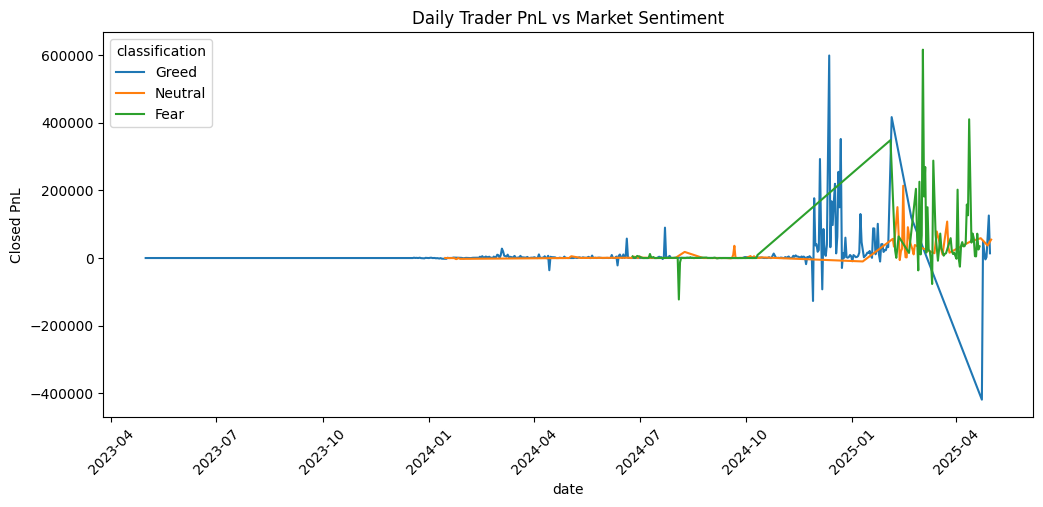

In [35]:
plt.figure(figsize=(12,5))
sns.lineplot(
    data=daily_pnl,
    x='date',
    y='Closed PnL',
    hue='classification'
)
plt.title("Daily Trader PnL vs Market Sentiment")
plt.xticks(rotation=45)
plt.show()


# Win Rate by Market Sentiment and Trade Direction
How often trades are profitable (win rate)
under different market moods (Fear vs Greed)
and for different trade directions (Buy vs Sell)


Win Rate by Sentiment and Trade Direction:
  classification  Side  is_profitable   win_rate
0           Fear   BUY       0.246718  24.671763
1           Fear  SELL       0.565855  56.585459
2          Greed   BUY       0.315270  31.526955
3          Greed  SELL       0.513782  51.378221
4        Neutral   BUY       0.240023  24.002320
5        Neutral  SELL       0.556072  55.607202


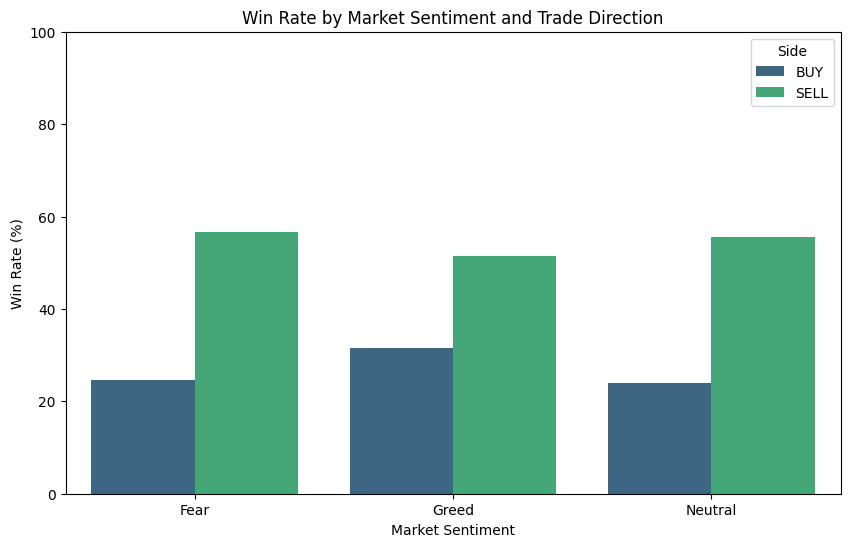

In [36]:
merged_df['is_profitable'] = merged_df['Closed PnL'] > 0

win_rate_by_sentiment_side = merged_df.groupby(['classification', 'Side'])['is_profitable'].mean().reset_index()
win_rate_by_sentiment_side['win_rate'] = win_rate_by_sentiment_side['is_profitable'] * 100

print("\nWin Rate by Sentiment and Trade Direction:")
print(win_rate_by_sentiment_side)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=win_rate_by_sentiment_side,
    x='classification',
    y='win_rate',
    hue='Side',
    palette='viridis'
)
plt.title('Win Rate by Market Sentiment and Trade Direction')
plt.ylabel('Win Rate (%)')
plt.xlabel('Market Sentiment')
plt.ylim(0, 100) # Win rate is a percentage
plt.show()